In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator, AutoLocator, MultipleLocator
import matplotlib.cm as cm
import PIL.Image as Image 
import matplotlib.image as img

colormap = cm.tab10

A Hopfield Network is a simple mathematical model of the brain that tries to emulate that brain function that allows one to memorize and recall them at the needed moment through what is called associative memory. In this sense, the Hopfield Network is a model of the associative memory function of the brain in which each the neurons and synapsis are described a magnetic system of $S_i=±1$ spins whose long range interactions are given by the Hamiltonian

$
H[S]=-\frac{1}{2}\sum_{i\neq j} J_{ij}S_i S_j.
$

Each neuron is a spin of two states connected to all other neurons with the coupling matrix $J_{ij}$ modeling the synaptic connections among different neurons. Memory is stored as a fixed configuration of $S_i = \xi_{i}$ such that when an input is provided to the network, it evolves dynamically until the stored associated configuration is reached. This information can be modeled as being encoded in the values taken by the synaptic connection between neurons, such that the synaptic weight matrix elements are defined by the following learning rule:

$
J_{ij} = \frac{1}{N} \sum_{\mu}^{P} \xi_{i}^{\mu} \xi_{j}^{\mu},
$

which is known as the Hebbian weight matrix and is computed as the sum of outer products, meaning the correlation or anti-correlation of the $i$-th and $j$-th spin for each $\mu$-th pattern to memorize, where $i, j = 1, ..., N$ and $\mu = 1, ...,  P$. It can be straightforwardly seen that the weight from neuron $i$ to $j$ is equal to that from $j$ to $i$, meaning the weight matrix of the Hopfield network must be fully symmetric, with no self-connection. 

The spins evolve iteratively following a sign update rule that is applied every time a neuron's output is taken as input by all other neurons, making the Hopfield network a fully connected feedback neural network. The order in which the update rule is applied can by synchronous, all neurons update their state simultaneously, or asynchronous, each one single neuron at random updates its state at each iteration. In the current deterministic case we use the following update rule:

$
S_i (t+1) = sgn(\sum_{j}^{N} J_{ij}S_i S_j).
$

Here we assume that, given a symmetric weight matrix and allowing the system to evolve asynchronously, the update rule is a Lyapunov function of the system, such that its dynamics are bound to settle to a fixed point, which is a local minimum of the Lyapunov function, and its state space can be divided into basins of attraction, one basin associated with each attractor. Some of the spurious stable states can in fact be associated with mixtures of the stored patterns.

Ultimately, the goal is to build a system that, for an initial condition randomly perturbed from a memory, will converge to the original memory's attractor. The system fails when it retrieves spurious attractors. We firstly aim to investigate two main aspects of the Hopfield network:

+ "storage capacity", meaning the relationship between the maximum number of patterns one can store in a given the neural network

+ "efficiency", how can we minimize the interference of spurious memories on successful patterns retrieval.

Spurious states are additional dynamic stable states that are not part of the stored memories and appear as local minima in the mean free energy of the system and essentially represent well-defined mixtures of several stored patterns.

Notes:

+ efficacy of the network by corrupting the memory -> randomly setting elements in the weight matrix to zero. 
+ add more memories -> basins of attraction shrink

In [69]:
# Paramenters
L = 25     # image edge size
N = L**2    # network size 
#P = 4       # number of patterns

np.random.seed(1234) # Seed for reproducibility of random number generation

(3, 25, 25)


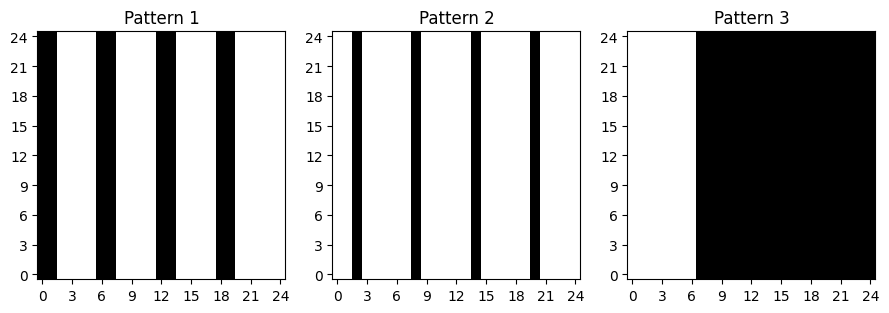

In [70]:
def generate_patterns(L: int):
    """ Generate inhomogeneous binary patterns (+1/-1) """
    return np.array([
        [[np.where(np.cos(x) > 0.5, 1, -1) for x in range(L)] for _ in range(L)],
        [[np.where(np.sin(x) > 0.9, 1, -1) for x in range(L)] for _ in range(L)],
        [[np.where(np.log(x) > 2, 1, -1) for x in range(1, L+1)] for _ in range(L)]
    ])

patterns = generate_patterns(L)
print(patterns.shape)
plt.figure(figsize=(9,5))
for p in range(patterns.shape[0]):
    plt.subplot(1, 3, p+1)
    plt.imshow(patterns[p], cmap='Greys')
    plt.xlim((-0.5, L-0.5))
    plt.ylim((-0.5,L-0.5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f"Pattern {p+1}")


plt.tight_layout()
plt.show()

In [79]:
def spin_distance(input_pattern: object, stored_pattern: object):
    """ Find the distance between the input pattern and a stored pattern"""
    si    = list(input_pattern.flatten())
    xi    = list(stored_pattern.flatten())
    
    N     = len(si)
    
    dist = np.sum([si[i]*xi[i] for i in range(N)]) / N
    return dist

input_pattern = patterns[1]
stored_pattern = patterns[0]
spin_distance(input_pattern, stored_pattern)

np.float64(0.04)

The synaptic weight matrix can be computed using the Hebbian rule:

$
J_{ij} = \frac{1}{N} \sum_{\mu=1}^{P}\xi_{i}^{\mu}\xi_{j}^{\mu}
$

where $\xi_{i}^{\mu}$ is the $i$-th state for the $\mu$-th pattern, with $i = 1, ..., N$ and $\mu = 1, ..., P$, and the Hebbian rule ensures that if the attractor's configuration is reached, at the successive time step the sign of each spin is maintained.

In [28]:
def weight_matrix(patterns: object):
    """ Compute Hopfield network weight matrix using Hebbian learning """
    num_patterns, rows, cols = patterns.shape
    N = rows*cols
    J = np.zeros((N, N))
    for p in patterns: J += 1/N * np.outer(p, p)
    np.fill_diagonal(J, 0)
    return J

J = weight_matrix(patterns)

In [29]:
#   Asynchronous update rule

def pattern_retrieval_async(input: object, J: object, steps: int):
    """Retrieve a pattern using asynchronous updates."""
    S = input.flatten()
    N = S.shape[0]
    for _ in range(steps):
        i = np.random.randint(0, N)  # Neuron selected randomly
        S[i] = np.sign(np.dot(J[i], S))  # and update at each step t
    return S.reshape((L, L))

In [30]:
def generate_random_patterns(L, P):
    """ Generate homogeneous binary patterns (+1/-1) """
    return np.array([np.where(np.random.rand(L, L) > 0.5, 1, -1) for p in range(P)])

Due to the interference of memorized patterns with the retrieval of the input pattern it can be shown that the theoretical storage limit of a Hopfield network is:

$
P_{\max} \approx 0.138 N.
$

For our random patterns we test different values of $P$ and check the accuracy of this simple Hopfield model.

In [11]:
def storage_capacity(L=20, max_P=50, trials=100):
    """ Test recall accuracy for different number of stored patterns """
    capacities = []
    
    for P in range(1, max_P):
        success_count = 0   # keep track of successfully retrieved patterns
        for _ in range(trials):
            # we generate new randomly distributed patterns at each iteration
            # to see how model is able to recognize original patterns
            random_patterns = generate_random_patterns(L=20, P=P)
            patterns_test = np.concatenate((patterns, random_patterns), axis=0)
            J = weight_matrix(patterns_test)
            
            # and check for successful pattern retrieval
            stable = all(np.all(
                pattern_retrieval_async(input=p, J=J, steps=100) == p
                ) for p in patterns_test)
            
            if stable:
                success_count += 1
        
        capacities.append((P/N, success_count / trials))
    
    return np.array(capacities)

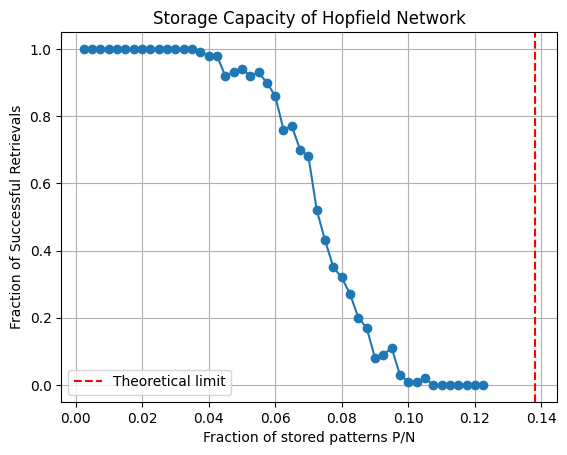

In [12]:
capacity_results = storage_capacity()

# Plot results
plt.plot(capacity_results[:, 0], capacity_results[:, 1], marker="o")
plt.axvline(x=0.138, color='r', linestyle='--', label="Theoretical limit")
plt.xlabel("Fraction of stored patterns P/N")
plt.ylabel("Fraction of Successful Retrievals")
plt.title("Storage Capacity of Hopfield Network")
plt.grid()
plt.legend()
plt.show()

We can introduce noise by randomly flipping bits in our input pattern and analyze retrieval.

In [ ]:
def introduce_noise(pattern, noise_level):
    """ Flip a fraction of bits in a pattern """
    noisy_pattern = pattern.copy()
    flip_indices = np.random.choice(len(pattern), int(noise_level * len(pattern)), replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

def basins_of_attraction(N, P, noise_levels):
    """ Measure how well patterns are retrieved under different noise levels """
    patterns = generate_random_patterns(N, P)
    J = weight_matrix(patterns)

    retrieval_rates = []
    for noise in noise_levels:
        successful_retrievals = 0
        for p in patterns:
            corrupted_p = introduce_noise(p, noise)
            recovered_p = pattern_retrieval_async(corrupted_p, J)
            if np.array_equal(recovered_p, p):
                successful_retrievals += 1
        
        retrieval_rates.append(successful_retrievals / P)
    
    return retrieval_rates

# Define noise levels and test retrieval robustness
noise_levels = np.linspace(0, 0.5, 10)
retrieval_results = basins_of_attraction(N=100, P=10, noise_levels=noise_levels)

# Plot results
plt.plot(noise_levels, retrieval_results, marker="o")
plt.xlabel("Noise Level")
plt.ylabel("Retrieval Accuracy")
plt.title("Basins of Attraction for Different Noise Levels")
plt.show()

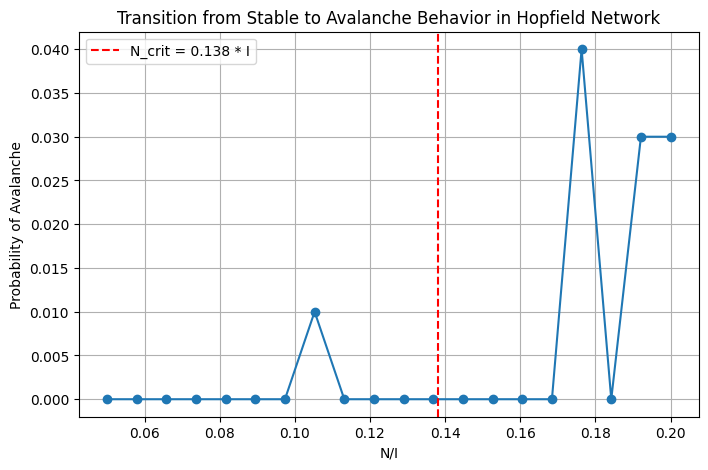

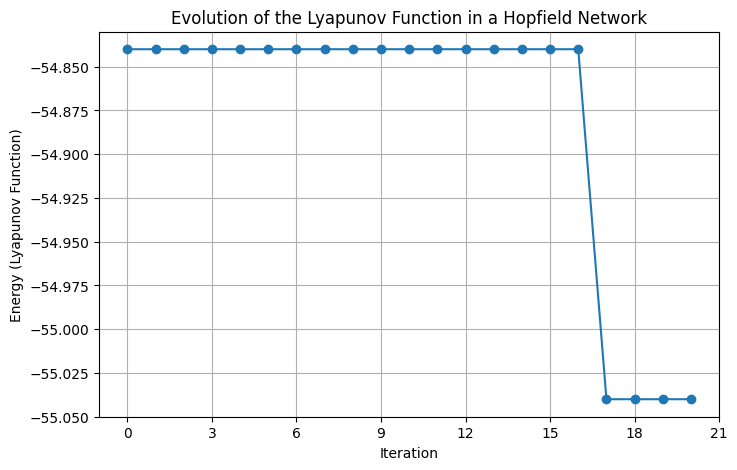

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoLocator, AutoMinorLocator, MultipleLocator

# Parameters
I = 100  # Number of neurons
N_values = np.linspace(0.05 * I, 0.2 * I, 20)  # Exploring values around N_crit = 0.138 * I
num_trials = 100  # Number of trials per N/I ratio

def energy_function(S, J):
    """Compute the energy (Lyapunov function) of a Hopfield network state."""
    return -0.5 * S @ J @ S

def generate_patterns(I, N):
    """Generate N random binary patterns of length I."""
    return np.where(np.random.rand(N, I) > 0.5, 1, -1)

def compute_weight_matrix(patterns):
    """Compute the Hopfield weight matrix using Hebbian learning."""
    J = np.tensordot(patterns, patterns, axes=(0, 0)) / patterns.shape[1]
    np.fill_diagonal(J, 0)  # Remove self-connections
    return J

def evolve_network(S, J, steps=10):
    """Evolve the Hopfield network asynchronously using efficient vectorized operations."""
    I = len(S)
    for _ in range(steps):
        i = np.random.randint(0, I)
        S[i] = np.sign(J[i] @ S)  # Vectorized update for neuron i
    return S

def simulate_avalanche(I, N, num_trials=10):
    """Simulate the probability of an avalanche occurring for given N/I ratio."""
    avalanche_count = 0

    for _ in range(num_trials):
        patterns = generate_patterns(I, N)
        J = compute_weight_matrix(patterns)

        initial_pattern = patterns[0].copy()
        noisy_pattern = initial_pattern.copy()
        noisy_pattern[:int(0.01 * I)] *= -1  # Introduce 1% corruption

        evolved_pattern = evolve_network(noisy_pattern, J, steps=100)

        # Compute overlap with original pattern
        overlap = np.mean(initial_pattern == evolved_pattern)

        if overlap < 0.95:  # If many bits flipped, avalanche has occurred
            avalanche_count += 1

    return avalanche_count / num_trials

# Simulate avalanches for different N/I values
avalanche_probabilities = np.array([simulate_avalanche(I, int(N), num_trials) for N in N_values])

# Plot the transition between stable and avalanche behavior
plt.figure(figsize=(8, 5))
plt.plot(N_values / I, avalanche_probabilities, marker='o', linestyle='-')
plt.axvline(x=0.138, color='r', linestyle='--', label="N_crit = 0.138 * I")
plt.xlabel("N/I")
plt.ylabel("Probability of Avalanche")
plt.title("Transition from Stable to Avalanche Behavior in Hopfield Network")
plt.legend()
plt.grid()
plt.show()

# Visualizing the Lyapunov Function
def visualize_lyapunov(I, N):
    """Plot the Lyapunov function for a given Hopfield network configuration."""
    patterns = generate_patterns(I, N)
    J = compute_weight_matrix(patterns)

    states = [patterns[0].copy()]
    energies = [energy_function(states[0], J)]

    for _ in range(20):  # Simulate network evolution
        new_state = evolve_network(states[-1], J, steps=1)
        states.append(new_state)
        energies.append(energy_function(new_state, J))

    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(energies)), energies, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Energy (Lyapunov Function)")
    plt.title("Evolution of the Lyapunov Function in a Hopfield Network")
    plt.grid()
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# Visualizing the Lyapunov function for a system at N/I = 0.1
visualize_lyapunov(I, int(0.1 * I))

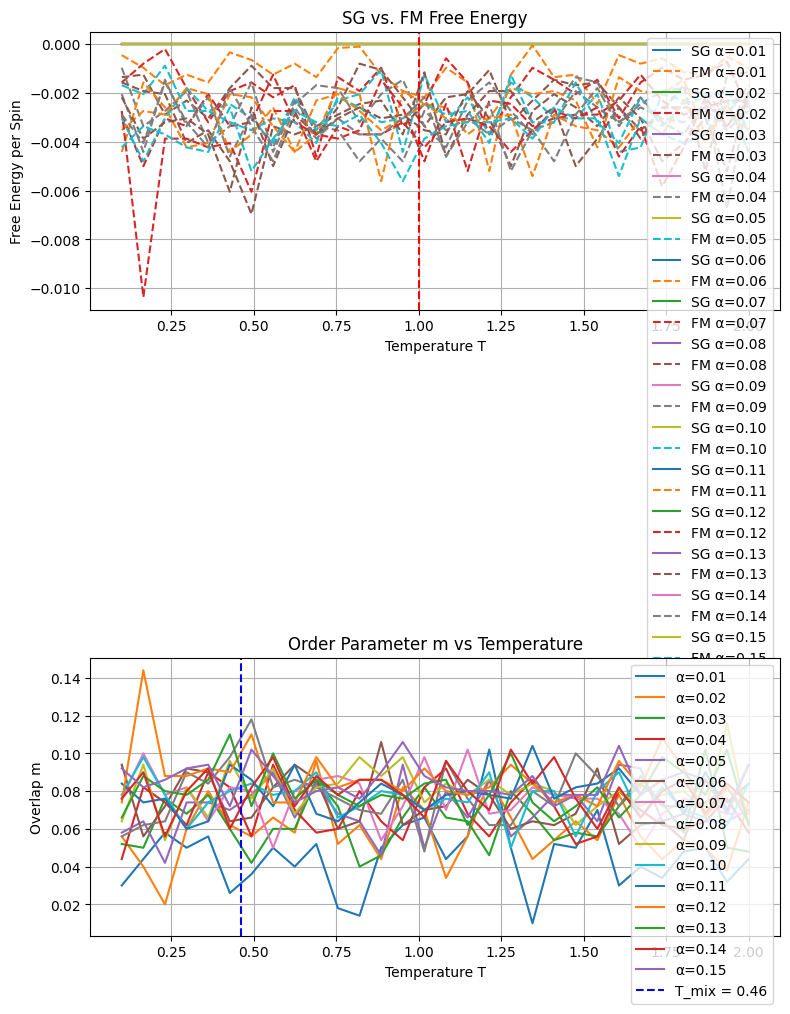

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameters
N = 1000  # Number of neurons
alpha_values = np.linspace(0.01, 0.15, 15)  # Range of α (p/N)
temperature_values = np.linspace(0.1, 2.0, 30)  # Range of temperatures

# Generate patterns
def generate_patterns(N, p):
    return np.where(np.random.rand(p, N) > 0.5, 1, -1)

# Compute weight matrix
def compute_weights(patterns):
    p, N = patterns.shape
    J = np.tensordot(patterns, patterns, axes=(0, 0)) / N
    np.fill_diagonal(J, 0)  # No self-connections
    return J

# Compute the overlap order parameter
def compute_overlap(S, patterns):
    """Computes overlap mν with each pattern and returns the max overlap"""
    overlaps = (1 / N) * np.dot(patterns, S)
    return np.max(overlaps)

# Monte Carlo evolution with temperature effects
def evolve_network(S, J, T, steps=1000):
    """Evolves the Hopfield network at temperature T using Glauber dynamics."""
    beta = 1 / T
    for _ in range(steps):
        i = np.random.randint(0, N)
        local_field = np.dot(J[i], S)
        P_flip = 1 / (1 + np.exp(2 * beta * local_field))
        if np.random.rand() < P_flip:
            S[i] *= -1  # Flip spin
    return S

# Free energy computation (mean-field)
def compute_free_energy(m, q, r, alpha, T):
    """Compute the free energy per spin based on order parameters."""
    return -0.5 * m**2 + (alpha / 2) * (1 / T) * np.log(1 - T * (1 - q))

# Simulate SG and FM phase transitions
SG_energies = []
FM_energies = []
order_parameters = []

for alpha in alpha_values:
    p = int(alpha * N)
    patterns = generate_patterns(N, p)
    J = compute_weights(patterns)
    
    sg_energy = []
    fm_energy = []
    overlaps = []

    for T in temperature_values:
        # Initial state (random)
        S = np.where(np.random.rand(N) > 0.5, 1, -1)
        
        # Evolve system
        evolved_S = evolve_network(S, J, T, steps=1000)
        
        # Compute order parameters
        m = compute_overlap(evolved_S, patterns)
        q = np.mean(evolved_S**2)
        r = q * (1 - alpha * (1 - q))

        # Compute free energy
        f_sg = compute_free_energy(0, q, r, alpha, T)  # SG phase (m=0)
        f_fm = compute_free_energy(m, q, r, alpha, T)  # FM phase (m≠0)

        sg_energy.append(f_sg)
        fm_energy.append(f_fm)
        overlaps.append(m)

    SG_energies.append(sg_energy)
    FM_energies.append(fm_energy)
    order_parameters.append(overlaps)

# Plot phase transition results
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

for i, alpha in enumerate(alpha_values):
    ax[0].plot(temperature_values, SG_energies[i], label=f"SG α={alpha:.2f}")
    ax[0].plot(temperature_values, FM_energies[i], linestyle="dashed", label=f"FM α={alpha:.2f}")

ax[0].axvline(x=1, color='r', linestyle='--', label="T_c = 1")
ax[0].set_xlabel("Temperature T")
ax[0].set_ylabel("Free Energy per Spin")
ax[0].set_title("SG vs. FM Free Energy")
ax[0].legend()
ax[0].grid()

for i, alpha in enumerate(alpha_values):
    ax[1].plot(temperature_values, order_parameters[i], label=f"α={alpha:.2f}")

ax[1].axvline(x=0.46, color='b', linestyle='--', label="T_mix = 0.46")
ax[1].set_xlabel("Temperature T")
ax[1].set_ylabel("Overlap m")
ax[1].set_title("Order Parameter m vs Temperature")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()